In [138]:
## Basic Packages

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from pandas.tools.plotting import parallel_coordinates

## Widget packages

from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets

## Sklearn packages
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

## Spotipy packages (Spotify API)

import spotipy
import spotipy.util as util

## Importing Bokeh to explore outliers

from bokeh.plotting import figure, output_file, show
import bokeh.models as bmo
from bokeh.palettes import d3
from bokeh.models import Legend, BoxSelectTool, BoxZoomTool, LassoSelectTool

## Notebook display settings
pd.options.display.max_columns = 999

In [48]:
## Audio feature descriptions

#https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/

In [49]:
## Read in data

combined_df = pd.read_csv('data/combined_df.csv')

In [50]:
## Trimming down the audio features that I want to explore initially

features_df = combined_df[['release_date', 'album_name', 'name', 'acousticness', 'danceability', 'energy', 
    'loudness', 'key', 'mode', 'tempo', 'valence']]

In [51]:
## Removing duplicate and greatest hits album

album_drop = ["""1 (Remastered)""", """Sgt. Pepper's Lonely Hearts Club Band (Deluxe Edition)""", """Live At The Hollywood Bowl"""]

features_df = features_df[~features_df['album_name'].isin(album_drop)]

In [52]:
## Separating the release date into year, month, day columns

features_df['year'], features_df['month'], features_df['day'] = features_df['release_date'].str.split('-',2).str

## Sort oldest album to newest album

features_df = features_df.sort_values(by = ['year', 'month', 'day'])

## Reset index and assign unique release dates to a list that will be used in the next loop

features_df.reset_index(drop = True, inplace = True)

unique_release = list(features_df.release_date.unique())

In [53]:
## For loop that assigns an album number based on the release date for future plotting

album_number = []

count = 0
record_number = 1

for row in range(len(features_df)):
    if features_df.release_date.iloc[row] == unique_release[count]:
        #print(features_df.release_date.iloc[row], "-------->", unique_release[count], "------->", features_df.release_date.iloc[row] == unique_release[count])
        album_number.append(record_number)
    else:
        #print('Change Album')
        record_number += 1
        count += 1
        album_number.append(record_number)

In [54]:
## Converting resulting list into a dataframe to concat, then renaming the column to show album_number

album_number = pd.DataFrame(album_number)

features_df = pd.concat([features_df, album_number], axis = 1)

features_df.rename(columns = {0 : 'album_number', 'name' : 'song_name'}, inplace = True)

## Creating raw dataframe for linear regression - song recommender

In [55]:
## Importing additional features from audio analysis

audio_analysis = pd.read_csv('data//audio_analysis.csv')
audio_analysis.drop(columns = ['Unnamed: 0'], inplace = True)

## Joining audio features with audio analysis

features_df_2 = features_df.merge(audio_analysis, how = 'left', on = 'song_name')

In [56]:
## Reading in song_composer details

song_composer = pd.read_csv('data/song_artist.csv')

song_composer = song_composer.iloc[:,-5:]

raw_features_df = features_df_2.merge(song_composer, how = 'left', on = 'song_name')

raw_features_df = raw_features_df[raw_features_df.duplicated(subset = 'song_name', keep = 'first') == False]

raw_features_df.reset_index(drop = True, inplace = True)

raw_features_df.rename(columns = {'album_name_x': 'album_name'}, inplace = True)

raw_features_df.drop(columns = ['album_name_y'], inplace = True)

In [57]:
raw_df_columns = list(raw_features_df.columns.values)

In [58]:
## Rearranging columns

raw_features_df = raw_features_df[[ 'release_date',
                                    'album_number',
                                    'album_name',
                                    'track_number',
                                    'song_name',
                                    'year',
                                    'month',
                                    'day',
                                    'acousticness',
                                    'danceability',
                                    'energy',
                                    'loudness',
                                    'valence',
                                    'song_length_seconds']]

In [59]:
## Reshaping dataframe to a long format

raw_feature_melt = pd.melt(raw_features_df, 
                           id_vars = ['release_date',
                                    'album_number',
                                    'album_name',
                                    'track_number',
                                    'song_name',
                                    'year',
                                    'month',
                                    'day',], 
                           var_name = 'feature', value_name = 'value')


In [60]:
## Function that takes a dataframe and iterates through columns to calculate predicted value

def future_value(df, req_feat):
    ## Will iterate through columns to calculate future value
    requested_df = df[df.feature == req_feat]

    x = np.array(requested_df.album_number)
    y = np.array(requested_df.value)

    fit = np.polyfit(x, y, 1)
    fit_fn = np.poly1d(fit) 

    ## Fit the linear regression model to the expected 14th value
    return fit_fn(14)

In [61]:
## Creating a key:value dictionary pair from the unique features
## This will be used by spotify to recommend similar songs to our predicted values

keys = []
values = []

unique_feat_list = list(raw_feature_melt.feature.unique())

for i in unique_feat_list:
    name = i
    keys.append(name)
    val = future_value(raw_feature_melt, i)
    values.append(val)

pred_dicts = dict(zip(keys, values))
        
#print(pred_dicts)

In [62]:
## Spotify asks for the recommended song length in ms

pred_dicts['song_length_seconds'] = round(pred_dicts['song_length_seconds']*1000)

In [63]:
pred_dicts

{'acousticness': 0.3062481815012571,
 'danceability': 0.46959219997513757,
 'energy': 0.4266455776734271,
 'loudness': -11.716340633032711,
 'valence': 0.4153814152407459,
 'song_length_seconds': 193251.0}

In [65]:
sp = spotipy.Spotify(auth=token)

NameError: name 'token' is not defined

In [66]:
#curl -X GET "https://api.spotify.com/v1/recommendations?seed_artists=4NHQUGzhtTLFvgF5SZesLK
#&seed_tracks=0c6xIDDpzE81m2q797ordA&min_energy=0.4&min_popularity=50&market=US" -H "Authorization: Bearer {your access token}"

artist = '3WrFJ7ztbogyGnTHbHJFl2'

results = sp.recommendations(seed_artists = artist, limit = 5, market = 'US', authorization= token,
                                     target_acousticness = pred_dicts['acousticness'],
                                     target_danceability = pred_dicts['danceability'],
                                     target_energy = pred_dicts['energy'],
                                     target_loudness = pred_dicts['loudness'],
                                     target_target_duration_ms = pred_dicts['song_length_seconds'],
                                     target_valence = pred_dicts['valence'])

NameError: name 'sp' is not defined

In [67]:
def recommendations(artist, dictionary):
        results = sp.recommendations(seed_artists = artist, limit = 5,
                                     target_acousticness = dictionary['acousticness'],
                                     target_danceability = dictionary['danceability'],
                                     target_energy = dictionary['energy'],
                                     target_loudness = dictionary['loudness'],
                                     target_target_duration_ms = pred_dicts['song_length_seconds'],
                                     target_valence = dictionary['valence'])
        recommend_df = pd.DataFrame(results)
        return recommend_df

In [68]:
future_songs = recommendations('3WrFJ7ztbogyGnTHbHJFl2', pred_dicts)

NameError: name 'sp' is not defined

## Looking at the distribution of the audio features per album

In [69]:
## Reducing features

audio_feat_dist = features_df[['album_name', 'acousticness', 'danceability', 'energy', 'loudness']]

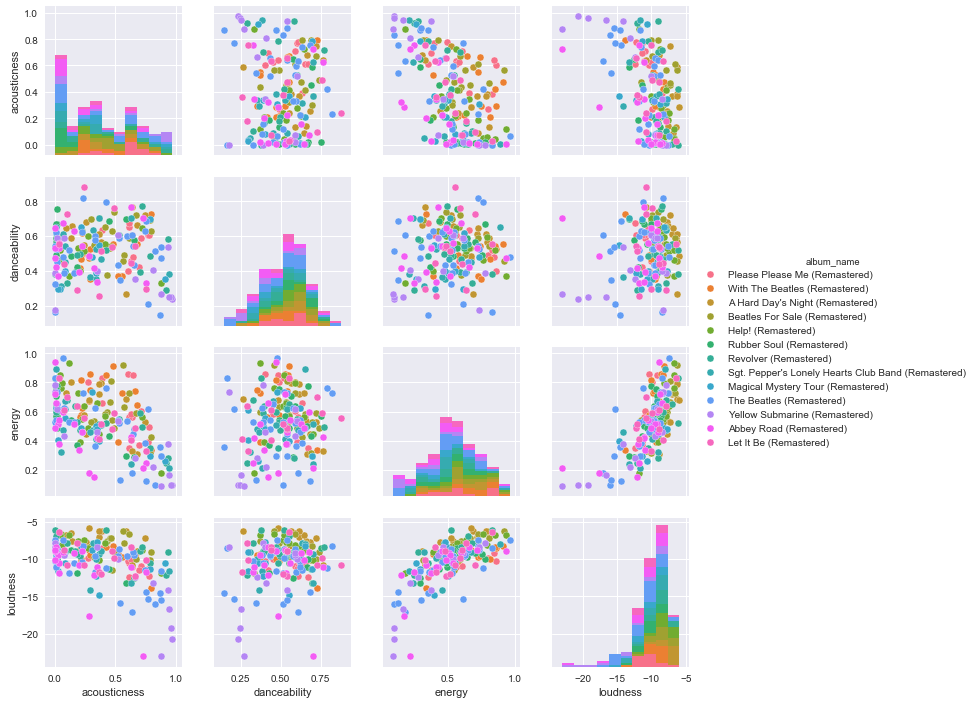

In [70]:
sns.set(rc={'figure.figsize':(12,12)})

_ = sns.pairplot(audio_feat_dist, hue = 'album_name')

## Regression plot of individual audio features

In [71]:
## Selecting features that I want to normalize

reg_features = features_df[['album_number', 
                            'song_name', 
                            'acousticness', 
                            'danceability', 
                            'energy', 
                            'loudness']]

## Importing additional features from audio analysis

audio_analysis = pd.read_csv('data//audio_analysis.csv')
audio_analysis.drop(columns = ['Unnamed: 0'], inplace = True)

## Joining audio features with audio analysis

reg_features = reg_features.merge(audio_analysis, how = 'left', on = 'song_name')

In [72]:
## Reading in song_composer details

song_composer = pd.read_csv('data/song_artist.csv')

song_composer = song_composer.iloc[:,-5:]

reg_features = reg_features.merge(song_composer, how = 'left', on = 'song_name')

reg_features = reg_features[reg_features.duplicated(subset = 'song_name', keep = 'first') == False]

reg_features.reset_index(drop = True, inplace = True)

In [73]:
#reg_features.to_csv('non-normalized_data.csv', index = False)

In [74]:
## Function to normalize features

def feature_norm(df, col):
    return(df[col] - df[col].min())/(df[col].max() - df[col].min())

In [75]:
feature_col_names = ['acousticness',
                     'danceability',
                     'energy',
                     'loudness',
                     'bars_count',
                     'beats_count',
                     'sections_count',
                     'segments_count',
                     'tatums_count',
                     'song_length_seconds',
                     'bpm']

In [76]:
## Iterating through columns to normalize the data 

for i in feature_col_names:
    reg_features[i] = feature_norm(reg_features, i)
    
reg_features.to_csv('data/normalized_audio_data.csv')

In [77]:
reg_features = pd.read_csv('data/normalized_audio_data.csv')

In [78]:
## Subsetting the data to average and visualize

normalized_features = reg_features[['album_number',
                                    'album_name',
                                     'acousticness',
                                     'danceability',
                                     'energy',
                                     'bars_count',
                                     'sections_count',
                                     'segments_count',
                                     'tatums_count',
                                     'song_length_seconds',
                                     'bpm',
                                     'McCartney',
                                     'Lennon',
                                     'Harrison',
                                     'Other']]

In [79]:
## Use pd.melt to create a lm plot for the features and values

normalized_features = pd.melt(normalized_features, id_vars = ['album_number', 'album_name'], var_name = 'feature', value_name = 'value')

## Making sure that the values are floats

normalized_features['value'] = normalized_features['value'].astype(float)

## Calculating the mean of each feature per album

album_means = normalized_features.groupby(['feature', 'album_number']).mean().reset_index().unstack(['feature'])

In [80]:
album_name_list = reg_features[reg_features.duplicated(subset = ['album_number', 'album_name'], keep = 'first') == False]

album_name_list = album_name_list[['album_number', 'album_name']]

In [172]:
## Creating a dataframe with averages for plotting purposes

norm_feats = normalized_features.groupby(['feature', 'album_number'])['value'].aggregate('mean').unstack(['feature'])

norm_feats['feat_means'] = 'feat_means'

norm_feats = pd.merge(norm_feats, album_name_list, how = 'left', on = 'album_number')

norm_feats = norm_feats[norm_feats.duplicated(subset = 'album_name', keep = 'last') == False]

norm_feats.reset_index(drop = True, inplace = True)

In [82]:
reg_features.columns.values

array(['Unnamed: 0', 'album_number', 'song_name', 'acousticness',
       'danceability', 'energy', 'loudness', 'track_number', 'album_name',
       'bars_count', 'beats_count', 'sections_count', 'segments_count',
       'tatums_count', 'song_length_seconds', 'bpm', 'McCartney',
       'Lennon', 'Harrison', 'Other'], dtype=object)

## Individual artist plots

In [83]:
def solo_data (author):
    solo_df = reg_features[reg_features[author] == 1]
    solo_df = solo_df[['album_number', 'acousticness', 'danceability',
       'energy', 'loudness', 'album_name', 'bars_count',
       'beats_count', 'sections_count', 'segments_count', 'tatums_count',
       'song_length_seconds', 'bpm', author]]
    normalized_features = pd.melt(solo_df, id_vars = ['album_number', 'album_name'], var_name = 'feature', value_name = 'value')

    return normalized_features

In [84]:
def cat_plot(df, x):
    if df == 'paul_df':
        df = paul_df
    elif df == 'john_df':
        df = john_df
    elif df == 'george_df':
        df = george_df
    else:
        df = other_df
    
    temp_df = df[df.feature == x]

    sns.lmplot(x="album_number", y="value", hue="feature", data = temp_df)

In [85]:
paul_df = solo_data('McCartney')

#sns.lmplot(x="album_number", y="value", hue="feature", data = paul_df)

In [86]:
john_df = solo_data('Lennon')

# sns.lmplot(x="album_number", y="value", hue="feature", data = john_df)

In [87]:
george_df = solo_data('Harrison')

# sns.lmplot(x="album_number", y="value", hue="feature", data = george_df)

In [88]:
other_df = solo_data('Other')

# sns.lmplot(x="album_number", y="value", hue="feature", data = other_df)

In [89]:
cat_drop = widgets.Dropdown(
    options=['acousticness', 'danceability', 'energy', 'loudness', 'bars_count',
       'beats_count', 'sections_count', 'segments_count', 'tatums_count',
       'song_length_seconds', 'bpm'
        ],
    description='Category:',
    disabled=False,
    readout=True,
)

df_button = widgets.RadioButtons(
    options=['paul_df', 'john_df', 'george_df', 'other_df'],
    value= 'paul_df',
    description='Choose dataframe:',
    disabled=False
)

In [90]:
widgets.interact(cat_plot, x= cat_drop, df = df_button);

interactive(children=(RadioButtons(description='Choose dataframe:', options=('paul_df', 'john_df', 'george_df'…

## Predicting future values for new songs

In [91]:
def future_value(df, req_feat):
    ## Takes the requested feature and calculates the regression line, then plots the regression line
    requested_df = df[df.feature == req_feat]

    x = np.array(requested_df.album_number)
    y = np.array(requested_df.value)

    fit = np.polyfit(x, y, 1)
    fit_fn = np.poly1d(fit) 

    #feature_plot = sns.lmplot(x="album_number", y="value", hue="feature", data = requested_df)
    print(fit_fn(14))

In [92]:
#unique_feat_list = paul_df.feature.unique()
#df_list = [paul_df, john_df, george_df, other_df]
for j in (paul_df, john_df, george_df, other_df):
    unique_feat_list = j.feature.unique()
    for i in unique_feat_list:
        future_value(j, i)
        print("^ - ", i)

0.35645225760473676
^ -  acousticness
0.5486694955816593
^ -  danceability
0.3768229497888424
^ -  energy
0.6785229954175901
^ -  loudness
0.3699808636830013
^ -  bars_count
0.35787814277269436
^ -  beats_count
0.3447708297837984
^ -  sections_count
0.2994310723041492
^ -  segments_count
0.3579447971816076
^ -  tatums_count
0.32270901443940947
^ -  song_length_seconds
0.4095970786032154
^ -  bpm
0.999999999999999
^ -  McCartney
0.19075511709345122
^ -  acousticness
0.3751098366139748
^ -  danceability
0.44585298176295957
^ -  energy
0.6823243024087418
^ -  loudness
0.41914728568962534
^ -  bars_count
0.41022603537753627
^ -  beats_count
0.3865036924603168
^ -  sections_count
0.3951729189667915
^ -  segments_count
0.4103062485120879
^ -  tatums_count
0.4194476826399687
^ -  song_length_seconds
0.36863257340915007
^ -  bpm
1.0
^ -  Lennon
0.11019878695152241
^ -  acousticness
0.43743814985020396
^ -  danceability
0.45884577265395043
^ -  energy
0.7253663535903037
^ -  loudness
0.48078658

## Correlation Matrix

In [205]:
## Creating an album list for labeling
reg_features = pd.read_csv('data/normalized_audio_data.csv')


album_list = list(features_df.album_name.unique())

In [206]:
corr_df = reg_features[[
             'acousticness',
             'danceability',
             'energy',
             'bars_count',
             'sections_count',
             'segments_count',
             'tatums_count',
             'song_length_seconds',
             'bpm',
             'McCartney',
             'Lennon',
             'Harrison',
             'Other']]

In [207]:
corr = corr_df.corr()
# sns.heatmap(corr, 
#             xticklabels=corr.columns.values,
#             yticklabels=corr.columns.values)

## PCA Analysis using sklearn

In [208]:
reg_features = reg_features.append(norm_feats)

C:\Users\Justin\AppData\Local\Programs\Python\Python36-32\lib\site-packages\pandas\core\frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


In [209]:
reg_features['feat_means'] = reg_features.feat_means.fillna('ind_feat')
reg_features['song_name'] = reg_features.song_name.fillna('Album Center!')
reg_features.reset_index(drop = True, inplace = True)

In [210]:
original_features_len = len(reg_features[reg_features.feat_means == 'ind_feat'])
print(original_features_len)

191


In [211]:
## Reducing features

pca_df = reg_features[['album_number',
                     'acousticness',
                     'danceability',
                     'energy',
                     'bars_count',
                     'sections_count',
                     'segments_count',
                     'tatums_count',
                     'song_length_seconds',
                     'bpm']]

## Splitting data into target and features

y = pca_df['album_number']
X_norm = pca_df.iloc[:,1:]

## Defining 4 components for PCA and applying fit_transform

pca = sklearnPCA(n_components = .95)
transformed = pd.DataFrame(pca.fit_transform(X_norm))

print(pca.explained_variance_)

print(pd.DataFrame(pca.components_,columns=X_norm.columns))

[0.11117688 0.08650604 0.03565914 0.02448829 0.02241448]
   acousticness  danceability    energy  bars_count  sections_count  \
0     -0.737623     -0.124107  0.413627    0.270630        0.153194   
1      0.428668     -0.374412 -0.299602    0.423974        0.293540   
2     -0.304584     -0.057405 -0.460812   -0.056975        0.227452   
3      0.258929      0.790520  0.272641    0.112898        0.225943   
4      0.334029     -0.461294  0.665882   -0.126942        0.054782   

   segments_count  tatums_count  song_length_seconds       bpm  
0        0.191214      0.260335             0.171760  0.197166  
1        0.217215      0.374255             0.264745  0.251075  
2        0.217217     -0.028172             0.271639 -0.717524  
3        0.267925      0.170990             0.231565 -0.123536  
4        0.130765     -0.088305             0.116698 -0.417855  


In [212]:
transformed_original = transformed.iloc[:original_features_len, :]
transformed_original.reset_index(drop = True, inplace = True)

transformed_mean = transformed.iloc[original_features_len:, :]
transformed_mean.reset_index(drop = True, inplace = True)

In [213]:
transformed_mean

,0,1,2,3,4
0,-0.162601,-0.003904,-0.168902,0.050155,0.069030
1,-0.015120,-0.099205,-0.101834,-0.009538,0.136062
2,-0.016284,-0.118678,-0.113121,0.059511,-0.025079
3,-0.114244,-0.018473,-0.145621,0.101115,0.021219
4,0.042593,-0.141096,-0.007608,-0.023351,0.038914
5,0.142244,-0.158919,0.066264,0.005058,-0.114188
6,-0.041832,0.004425,-0.033290,-0.060473,0.015648
7,0.073464,0.050366,0.105378,0.007733,-0.048666
8,0.071360,0.073485,0.147545,-0.021588,0.017025
9,0.011602,0.087195,0.052854,0.021025,0.004796


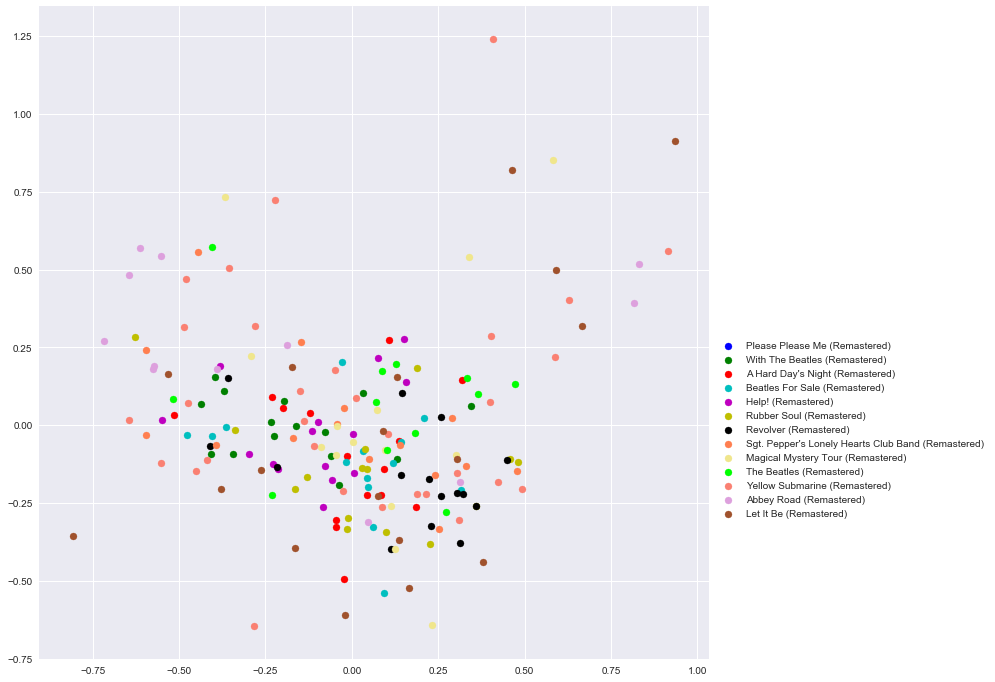

In [214]:
## Plotting results of PCA transformation
color_list = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'coral', 'khaki', 'lime', 'salmon', 'plum', 'sienna']

sns.set(rc={'figure.figsize':(12,12)})

for i in range(len(album_list)):
    plt.scatter(transformed[y == i][0], transformed[y == i][1], label = album_list[i], c = color_list[i])

#for i in range(len(album_list)):
#    plt.scatter(norm_feats[y == i][0], y = norm_feats.)

plt.legend(bbox_to_anchor=(1, 0.5))
plt.show()

## PCA in Bokeh to utilize hover feature and explore outliers

In [257]:
## Creating new df for interactive Bokeh graphs

graph_df = pd.concat([reg_features[['album_name', 'song_name', 'album_number']], transformed.iloc[:,:2]], axis=1, join_axes=[reg_features.index])

graph_df.rename(columns = {0 : 'x', 1 : 'y'}, inplace = True)

In [296]:
## Resetting the html output to prevent multiple graphs from showing up

bpl.reset_output()

## Hover tool set to show album number, album name and song name

hover = bmo.HoverTool(
    tooltips = [
        ('Album #: ', '@album_number'),
        ('Album Name: ', '@album_name'),
        ('Song Name: ', '@song_name')])

## Configuring tools that will be used in the plot (plot size is large for viewing on monitor and not laptop)

p = figure(tools = [hover, "box_select, box_zoom, lasso_select, reset"], plot_width = 1600, plot_height = 1200,  toolbar_location = 'above')

#p = figure(tools = [hover, "box_select, box_zoom, lasso_select, reset"], plot_width = 800, plot_height = 600)

## Creating scatter plots for each plot

bokeh_plot_0 = p.circle(x = 'x', y = 'y', source = graph_df[graph_df.album_name == album_list[0]], color = palette[0], 
                        size = 6, alpha = 0.75, muted_color = palette[0], muted_alpha = 0.1)
bokeh_plot_1 = p.circle(x = 'x', y = 'y', source = graph_df[graph_df.album_name == album_list[1]], color = palette[1], 
                        size = 6, alpha = 0.75, muted_color = palette[1], muted_alpha = 0.1)
bokeh_plot_2 = p.circle(x = 'x', y = 'y', source = graph_df[graph_df.album_name == album_list[2]], color = palette[2], 
                        size = 6, alpha = 0.75, muted_color = palette[2], muted_alpha = 0.1)
bokeh_plot_3 = p.circle(x = 'x', y = 'y', source = graph_df[graph_df.album_name == album_list[3]], color = palette[3], 
                        size = 6, alpha = 0.75, muted_color = palette[3], muted_alpha = 0.1)
bokeh_plot_4 = p.circle(x = 'x', y = 'y', source = graph_df[graph_df.album_name == album_list[4]], color = palette[4], 
                        size = 6, alpha = 0.75, muted_color = palette[4], muted_alpha = 0.1)
bokeh_plot_5 = p.circle(x = 'x', y = 'y', source = graph_df[graph_df.album_name == album_list[5]], color = palette[5], 
                        size = 6, alpha = 0.75, muted_color = palette[5], muted_alpha = 0.1)
bokeh_plot_6 = p.circle(x = 'x', y = 'y', source = graph_df[graph_df.album_name == album_list[6]], color = palette[6], 
                        size = 6, alpha = 0.75, muted_color = palette[6], muted_alpha = 0.1)
bokeh_plot_7 = p.circle(x = 'x', y = 'y', source = graph_df[graph_df.album_name == album_list[7]], color = palette[7], 
                        size = 6, alpha = 0.75, muted_color = palette[7], muted_alpha = 0.1)
bokeh_plot_8 = p.circle(x = 'x', y = 'y', source = graph_df[graph_df.album_name == album_list[8]], color = palette[8], 
                        size = 6, alpha = 0.75, muted_color = palette[8], muted_alpha = 0.1)
bokeh_plot_9 = p.circle(x = 'x', y = 'y', source = graph_df[graph_df.album_name == album_list[9]], color = palette[9], 
                        size = 6, alpha = 0.75, muted_color = palette[9], muted_alpha = 0.1)
bokeh_plot_10 = p.circle(x = 'x', y = 'y', source = graph_df[graph_df.album_name == album_list[10]], color = palette[10], 
                        size = 6, alpha = 0.75, muted_color = palette[10], muted_alpha = 0.1)
bokeh_plot_11 = p.circle(x = 'x', y = 'y', source = graph_df[graph_df.album_name == album_list[11]], color = palette[11], 
                        size = 6, alpha = 0.75, muted_color = palette[11], muted_alpha = 0.1)
bokeh_plot_12 = p.circle(x = 'x', y = 'y', source = graph_df[graph_df.album_name == album_list[12]], color = palette[12], 
                        size = 6, alpha = 0.75, muted_color = palette[12], muted_alpha = 0.1)


## Creating legend to allow filtering by album. Legend will display to the right of the graph

legend = Legend(items = [
        (album_list[0], [bokeh_plot_0]),
        (album_list[1], [bokeh_plot_1]),
        (album_list[2], [bokeh_plot_2]),
        (album_list[3], [bokeh_plot_3]),
        (album_list[4], [bokeh_plot_4]),
        (album_list[5], [bokeh_plot_5]),
        (album_list[6], [bokeh_plot_6]),
        (album_list[7], [bokeh_plot_7]),
        (album_list[8], [bokeh_plot_8]),
        (album_list[9], [bokeh_plot_9]),
        (album_list[10], [bokeh_plot_10]),
        (album_list[11], [bokeh_plot_11]),
        (album_list[12], [bokeh_plot_12])], 
        location=(0, 30))


p.add_layout(legend, 'right')
p.legend.click_policy = 'mute'

## Removing all lines and text, since location on the grid doesn't add any information for analysis

p.xaxis.major_tick_line_color = None
p.xaxis.minor_tick_line_color = None
p.xaxis.axis_line_color = None
p.xaxis.major_label_text_font_size = '0pt'

p.yaxis.major_tick_line_color = None
p.yaxis.minor_tick_line_color = None
p.yaxis.axis_line_color = None
p.yaxis.major_label_text_font_size = '0pt'

p.grid.visible = False

## Creating color palette/map

palette = d3['Category20'][len(graph_df['album_name'].unique())]
color_map = bmo.CategoricalColorMapper(factors = graph_df['album_name'].unique(), palette = palette) 

p.background_fill_color = 'beige'
p.background_fill_alpha = 0.5

## Show the Results

output_file("PCA_beatles.html")
bpl.output_notebook()
show(p)

Loading BokehJS ...

## Linear Discriminant Analysis

In [297]:
## Defining 4 components for LDA and applying fit_transform

lda = LinearDiscriminantAnalysis(n_components = 5)
transformed_2 = pd.DataFrame(lda.fit_transform(X_norm, y))

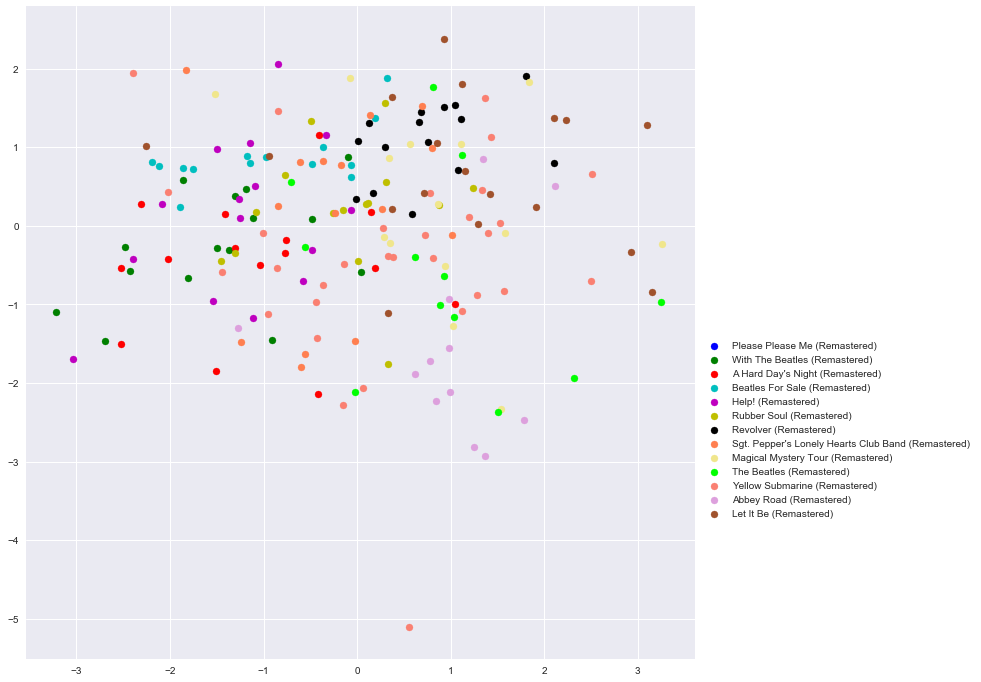

In [298]:
## Plotting results of LDA transformation

for i in range(len(album_list)):
    plt.scatter(transformed_2[y == i][0], transformed_2[y == i][1], label = album_list[i], c = color_list[i])

plt.legend(bbox_to_anchor=(1, 0.5))
plt.show()

## t-SNE clustering

In [299]:
## Defining 4 components for LDA and applying fit_transform

tsne = TSNE(n_components = 2, perplexity = 80, learning_rate = 850)
transformed_3 = pd.DataFrame(tsne.fit_transform(transformed_2))

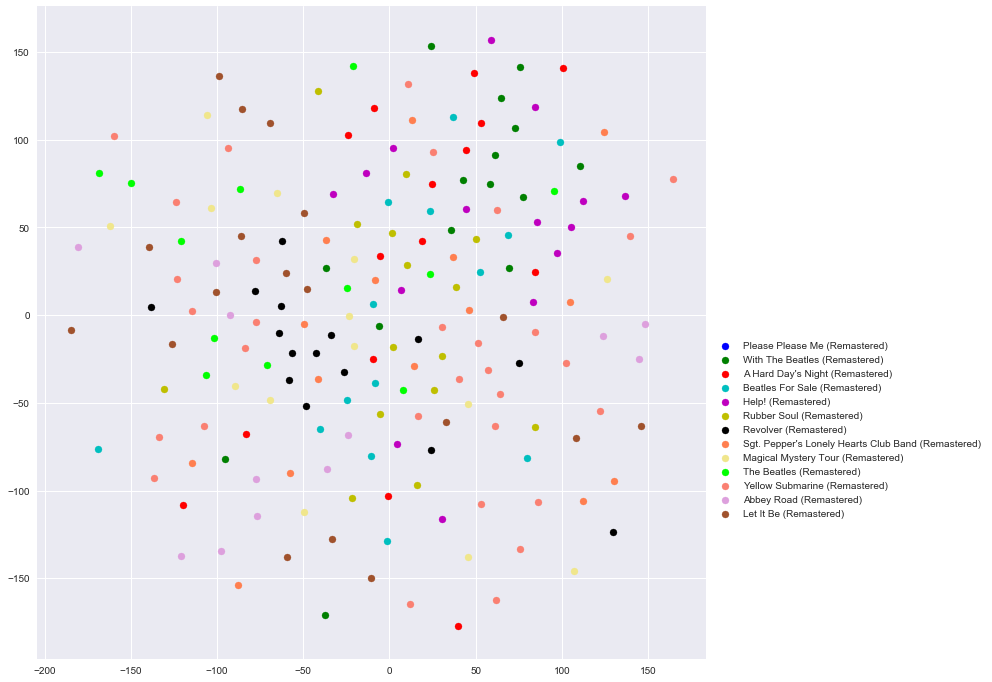

In [300]:
## Plotting results of t-SNE transformation

for i in range(len(album_list)):
    plt.scatter(transformed_3[y == i][0], transformed_3[y == i][1], label = album_list[i], c = color_list[i])

plt.legend(bbox_to_anchor=(1, 0.5))
plt.show()

## t-SNE clustering in Bokeh

In [302]:
## Creating new df for interactive Bokeh graphs

tsne_df = pd.concat([reg_features[['album_name', 'song_name', 'album_number']], transformed_3.iloc[:,:2]], axis=1, join_axes=[reg_features.index])

tsne_df.rename(columns = {0 : 'x', 1 : 'y'}, inplace = True)

In [304]:
## Resetting the html output to prevent multiple graphs from showing up

bpl.reset_output()

## Hover tool set to show album number, album name and song name

hover = bmo.HoverTool(
    tooltips = [
        ('Album #: ', '@album_number'),
        ('Album Name: ', '@album_name'),
        ('Song Name: ', '@song_name')])

## Configuring tools that will be used in the plot (plot size is large for viewing on monitor and not laptop)

p = figure(tools = [hover, "box_select, box_zoom, lasso_select, reset"], plot_width = 1600, plot_height = 1200,  toolbar_location = 'above')

#p = figure(tools = [hover, "box_select, box_zoom, lasso_select, reset"], plot_width = 800, plot_height = 600)

## Creating scatter plots for each plot

tsne_plot_0 = p.circle(x = 'x', y = 'y', source = tsne_df[tsne_df.album_name == album_list[0]], color = palette[0], 
                        size = 6, alpha = 0.75, muted_color = palette[0], muted_alpha = 0.1)
tsne_plot_1 = p.circle(x = 'x', y = 'y', source = tsne_df[tsne_df.album_name == album_list[1]], color = palette[1], 
                        size = 6, alpha = 0.75, muted_color = palette[1], muted_alpha = 0.1)
tsne_plot_2 = p.circle(x = 'x', y = 'y', source = tsne_df[tsne_df.album_name == album_list[2]], color = palette[2], 
                        size = 6, alpha = 0.75, muted_color = palette[2], muted_alpha = 0.1)
tsne_plot_3 = p.circle(x = 'x', y = 'y', source = tsne_df[tsne_df.album_name == album_list[3]], color = palette[3], 
                        size = 6, alpha = 0.75, muted_color = palette[3], muted_alpha = 0.1)
tsne_plot_4 = p.circle(x = 'x', y = 'y', source = tsne_df[tsne_df.album_name == album_list[4]], color = palette[4], 
                        size = 6, alpha = 0.75, muted_color = palette[4], muted_alpha = 0.1)
tsne_plot_5 = p.circle(x = 'x', y = 'y', source = tsne_df[tsne_df.album_name == album_list[5]], color = palette[5], 
                        size = 6, alpha = 0.75, muted_color = palette[5], muted_alpha = 0.1)
tsne_plot_6 = p.circle(x = 'x', y = 'y', source = tsne_df[tsne_df.album_name == album_list[6]], color = palette[6], 
                        size = 6, alpha = 0.75, muted_color = palette[6], muted_alpha = 0.1)
tsne_plot_7 = p.circle(x = 'x', y = 'y', source = tsne_df[tsne_df.album_name == album_list[7]], color = palette[7], 
                        size = 6, alpha = 0.75, muted_color = palette[7], muted_alpha = 0.1)
tsne_plot_8 = p.circle(x = 'x', y = 'y', source = tsne_df[tsne_df.album_name == album_list[8]], color = palette[8], 
                        size = 6, alpha = 0.75, muted_color = palette[8], muted_alpha = 0.1)
tsne_plot_9 = p.circle(x = 'x', y = 'y', source = tsne_df[tsne_df.album_name == album_list[9]], color = palette[9], 
                        size = 6, alpha = 0.75, muted_color = palette[9], muted_alpha = 0.1)
tsne_plot_10 = p.circle(x = 'x', y = 'y', source = tsne_df[tsne_df.album_name == album_list[10]], color = palette[10], 
                        size = 6, alpha = 0.75, muted_color = palette[10], muted_alpha = 0.1)
tsne_plot_11 = p.circle(x = 'x', y = 'y', source = tsne_df[tsne_df.album_name == album_list[11]], color = palette[11], 
                        size = 6, alpha = 0.75, muted_color = palette[11], muted_alpha = 0.1)
tsne_plot_12 = p.circle(x = 'x', y = 'y', source = tsne_df[tsne_df.album_name == album_list[12]], color = palette[12], 
                        size = 6, alpha = 0.75, muted_color = palette[12], muted_alpha = 0.1)


## Creating legend to allow filtering by album. Legend will display to the right of the graph

legend = Legend(items = [
        (album_list[0], [tsne_plot_0]),
        (album_list[1], [tsne_plot_1]),
        (album_list[2], [tsne_plot_2]),
        (album_list[3], [tsne_plot_3]),
        (album_list[4], [tsne_plot_4]),
        (album_list[5], [tsne_plot_5]),
        (album_list[6], [tsne_plot_6]),
        (album_list[7], [tsne_plot_7]),
        (album_list[8], [tsne_plot_8]),
        (album_list[9], [tsne_plot_9]),
        (album_list[10], [tsne_plot_10]),
        (album_list[11], [tsne_plot_11]),
        (album_list[12], [tsne_plot_12])], 
        location=(0, 30))


p.add_layout(legend, 'right')
p.legend.click_policy = 'mute'

## Removing all lines and text, since location on the grid doesn't add any information for analysis

p.xaxis.major_tick_line_color = None
p.xaxis.minor_tick_line_color = None
p.xaxis.axis_line_color = None
p.xaxis.major_label_text_font_size = '0pt'

p.yaxis.major_tick_line_color = None
p.yaxis.minor_tick_line_color = None
p.yaxis.axis_line_color = None
p.yaxis.major_label_text_font_size = '0pt'

p.grid.visible = False

## Creating color palette/map

palette = d3['Category20'][len(tsne_df['album_name'].unique())]
color_map = bmo.CategoricalColorMapper(factors = tsne_df['album_name'].unique(), palette = palette) 

p.background_fill_color = 'beige'
p.background_fill_alpha = 0.5

## Show the Results

output_file("TSNE_beatles.html")
bpl.output_notebook()
show(p)

Loading BokehJS ...